# This kernel is U-Net Baseline written by PyTorch
In this kernel, there are many places that are simplified now.  
So, you should fix these bad points.  

[U-Net web site](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)  
[U-Net paper](https://arxiv.org/abs/1505.04597)  

I reference [this blog post](https://lp-tech.net/articles/hzfn7?page=2  ) in U-Net installation.  
Thank you awesome this blog post.  

This is [my EDA](https://www.kaggle.com/go1dfish/fgvc6-simple-eda).  
If you don't know this competition rule and data, this EDA might help you.  

# Import modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("input"))
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from itertools import groupby

['label_descriptions.json', 'train.csv', 'train', 'test', 'sample_submission.csv']


In [2]:
input_dir = "input/"
train_img_dir = input_dir + "train/"
test_img_dir = input_dir + "test/"

WIDTH = 224
HEIGHT = 224
category_num = 1 + 1

ratio = 8

epoch_num = 4
batch_size = 8

device = "cuda:0"
# device = torch.device('cpu')

In [3]:
len(os.listdir("input/train/"))

45196

In [4]:
len(os.listdir("input/test/"))

3194

In [5]:
train_df = pd.read_csv(input_dir + "train.csv")
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [6]:
# train_df['ClassId'][train_df['ClassId'] == 46] = 0
# train_df['ClassId'][train_df['ClassId'] != 46] = 1

# Define utils
For suniqueicity, It focus only category

In [7]:
def make_onehot_vec(x):
    vec = np.zeros(category_num)
    vec[x] = 1
    return vec

In [8]:
def make_mask_img(segment_df):
    seg_width = segment_df.at[0, "Width"]
    seg_height = segment_df.at[0, "Height"]
    seg_img = np.full(seg_width*seg_height, category_num-1, dtype=np.int32)
    for encoded_pixels, class_id in zip(segment_df["EncodedPixels"].values, segment_df["ClassId"].values):
        pixel_list = list(map(int, encoded_pixels.split(" ")))
        for i in range(0, len(pixel_list), 2):
            start_index = pixel_list[i] - 1
            index_len = pixel_list[i+1] - 1
            seg_img[start_index:start_index+index_len] = int(class_id.split("_")[0])
    seg_img = seg_img.reshape((seg_height, seg_width), order='F')
    seg_img = cv2.resize(seg_img, (WIDTH, HEIGHT), interpolation=cv2.INTER_NEAREST)
    """
    seg_img_onehot = np.zeros((HEIGHT, WIDTH, category_num), dtype=np.int32)
    #seg_img_onehot = np.zeros((seg_height//ratio, seg_width//ratio, category_num), dtype=np.int32)
    # OPTIMIZE: slow
    for ind in range(HEIGHT):
        for col in range(WIDTH):
            seg_img_onehot[ind, col] = make_onehot_vec(seg_img[ind, col])
    """
    return seg_img

In [9]:
def train_generator(df, batch_size):
    img_ind_num = df.groupby("ImageId")["ClassId"].count()
    index = df.index.values[0]
    trn_images = []
    seg_images = []
    for i, (img_name, ind_num) in enumerate(img_ind_num.items()):
        img = cv2.imread(train_img_dir + img_name)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
        segment_df = (df.loc[index:index+ind_num-1, :]).reset_index(drop=True)
        index += ind_num
        if segment_df["ImageId"].nunique() != 1:
            raise Exception("Index Range Error")
        seg_img = make_mask_img(segment_df)
        
        # HWC -> CHW
        img = img.transpose((2, 0, 1))
        #seg_img = seg_img.transpose((2, 0, 1))
        
        trn_images.append(img)
        seg_images.append(seg_img)
        if((i+1) % batch_size == 0):
            yield np.array(trn_images, dtype=np.float32) / 255, np.array(seg_images, dtype=np.int32)
            trn_images = []
            seg_images = []
    if(len(trn_images) != 0):
        yield np.array(trn_images, dtype=np.float32) / 255, np.array(seg_images, dtype=np.int32)

In [10]:
def test_generator(df):
    img_names = df["ImageId"].values
    for img_name in img_names:
        img = cv2.imread(test_img_dir + img_name)
        img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
        # HWC -> CHW
        img = img.transpose((2, 0, 1))
        yield img_name, np.asarray([img], dtype=np.float32) / 255

In [11]:
def encode(input_string):
    return [(len(list(g)), k) for k,g in groupby(input_string)]

def run_length(label_vec):
    encode_list = encode(label_vec)
    index = 1
    class_dict = {}
    for i in encode_list:
        if i[1] != category_num-1:
            if i[1] not in class_dict.keys():
                class_dict[i[1]] = []
            class_dict[i[1]] = class_dict[i[1]] + [index, i[0]]
        index += i[0]
    return class_dict

# Define Network

In [12]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

# Training

In [13]:
train_df.shape

(331213, 5)

In [14]:
333415 // 4

83353

In [15]:
train_df.iloc[83348:83354, :]

,ImageId,EncodedPixels,Height,Width,ClassId
83348,404b0d1b58a1af0841e1e46f975118eb.jpg,337743 2 338739 6 339735 10 340732 13 341728 1...,1000,667,22
83349,404b0d1b58a1af0841e1e46f975118eb.jpg,235561 2 236558 5 237554 9 238551 13 239549 15...,1000,667,8
83350,404b0d1b58a1af0841e1e46f975118eb.jpg,219425 10 220411 30 221398 50 222385 68 223374...,1000,667,0
83351,404b0d1b58a1af0841e1e46f975118eb.jpg,298226 2 299225 7 300225 11 301225 14 302224 1...,1000,667,28
83352,404b0d1b58a1af0841e1e46f975118eb.jpg,379364 12 380342 1 380352 27 381340 4 381351 3...,1000,667,31
83353,404b0d1b58a1af0841e1e46f975118eb.jpg,219425 10 220411 30 221398 50 222385 68 223374...,1000,667,31


In [16]:
train_df.iloc[73350:73354, :]

,ImageId,EncodedPixels,Height,Width,ClassId
73350,3892703cf1e7f6a3cc1892fcb3daedae.jpg,85434 2 88642 6 91851 9 95059 14 98268 17 1014...,3211,2141,31
73351,3892703cf1e7f6a3cc1892fcb3daedae.jpg,82220 2 85428 6 88637 9 91846 13 95055 16 9826...,3211,2141,1
73352,3893868714043964534a6cdbaf1f0d75.jpg,7536415 56 7542028 60 7547642 62 7553255 65 75...,5616,3744,23
73353,3893868714043964534a6cdbaf1f0d75.jpg,12534531 11 12540144 33 12545757 55 12551369 6...,5616,3744,23


For simplicity, use about 25% data.  

In [17]:
net = UNet(n_channels=3, n_classes=category_num).to(device)

# optimizer = optim.SGD(
#     net.parameters(),
#     lr=0.01,
#     momentum=0.9,
#     weight_decay=0.0005
# )
optimizer = optim.Adam(net.parameters(),
                       lr=0.01
                      )

criterion = nn.CrossEntropyLoss()

In [ ]:
net.load_state_dict(torch.load('w.pth'))

In [99]:
val_sta = 73352
val_end = 83351
train_loss = []
valid_loss = []
for epoch in range(epoch_num):
    epoch_trn_loss = 0
    train_len = 0
    net.train()
    for iteration, (X_trn, Y_trn) in enumerate(tqdm(train_generator(train_df.iloc[:val_sta, :], batch_size))):
        Y_trn[Y_trn == 1] = 0
        Y_trn[Y_trn != 0] = 1
        X = torch.tensor(X_trn, dtype=torch.float32).to(device)
        Y = torch.tensor(Y_trn, dtype=torch.long).to(device)
        train_len += len(X)
        
        #Y_flat = Y.view(-1)
        mask_pred = net(X)
        #mask_prob = torch.softmax(mask_pred, dim=1)
        #mask_prob_flat = mask_prob.view(-1)
        loss = criterion(mask_pred, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_trn_loss += loss.item()
        
        if iteration % 100 == 0:
            print("train loss in {:0>2}epoch  /{:>5}iter:    {:<10.8}".format(epoch+1, iteration, epoch_trn_loss/(iteration+1)))
        
    train_loss.append(epoch_trn_loss/(iteration+1))
    print("train {}epoch loss({}iteration):    {:10.8}".format(epoch+1, iteration, train_loss[-1]))
    
    epoch_val_loss = 0
    val_len = 0
    net.eval()
#     for iteration, (X_val, Y_val) in enumerate(tqdm(train_generator(train_df.iloc[val_sta:val_end, :], batch_size))):
#         Y_val[Y_val == 1] = 0
#         Y_val[Y_val != 0] = 1
#         X = torch.tensor(X_val, dtype=torch.float32).to(device)
#         Y = torch.tensor(Y_val, dtype=torch.long).to(device)
#         val_len += len(X)
        
#         #Y_flat = Y.view(-1)
        
#         mask_pred = net(X)
#         #mask_prob = torch.softmax(mask_pred, dim=1)
#         #mask_prob_flat = mask_prob.view(-1)
#         loss = criterion(mask_pred, Y)
#         epoch_val_loss += loss.item()
        
#         if iteration % 100 == 0:
#             print("valid loss in {:0>2}epoch  /{:>5}iter:    {:<10.8}".format(epoch+1, iteration, epoch_val_loss/(iteration+1)))
        
    valid_loss.append(epoch_val_loss/(iteration+1))
    print("valid {}epoch loss({}iteration):    {:10.8}".format(epoch+1, iteration, valid_loss[-1]))

<ipython-input-99-3401c2a0f8ae>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iteration, (X_trn, Y_trn) in enumerate(tqdm(train_generator(train_df.iloc[:val_sta, :], batch_size))):


train loss in 01epoch  /    0iter:    0.48244777
train loss in 01epoch  /  100iter:    0.4188875 
train loss in 01epoch  /  200iter:    0.38496849
train loss in 01epoch  /  300iter:    0.36789627
train loss in 01epoch  /  400iter:    0.35921227
train loss in 01epoch  /  500iter:    0.35193099
train loss in 01epoch  /  600iter:    0.34690535
train loss in 01epoch  /  700iter:    0.34382413
train loss in 01epoch  /  800iter:    0.33933571
train loss in 01epoch  /  900iter:    0.33441083
train loss in 01epoch  / 1000iter:    0.33221865
train loss in 01epoch  / 1100iter:    0.32820888
train loss in 01epoch  / 1200iter:    0.32407237

train 1epoch loss(1251iteration):    0.32274931
valid 1epoch loss(1251iteration):           0.0


train loss in 02epoch  /    0iter:    0.39506108
train loss in 02epoch  /  100iter:    0.27711976
train loss in 02epoch  /  200iter:    0.27868444
train loss in 02epoch  /  300iter:    0.27533482
train loss in 02epoch  /  400iter:    0.27379406
train loss in 02epoch  /  500iter:    0.27165127
train loss in 02epoch  /  600iter:    0.27052967
train loss in 02epoch  /  700iter:    0.27062766
train loss in 02epoch  /  800iter:    0.26884806
train loss in 02epoch  /  900iter:    0.26586354
train loss in 02epoch  / 1000iter:    0.26555444
train loss in 02epoch  / 1100iter:    0.2635777 
train loss in 02epoch  / 1200iter:    0.26072175

train 2epoch loss(1251iteration):    0.26004256
valid 2epoch loss(1251iteration):           0.0


train loss in 03epoch  /    0iter:    0.33171886
train loss in 03epoch  /  100iter:    0.23228856
train loss in 03epoch  /  200iter:    0.23762929
train loss in 03epoch  /  300iter:    0.23545219
train loss in 03epoch  /  400iter:    0.23394902
train loss in 03epoch  /  500iter:    0.23240549
train loss in 03epoch  /  600iter:    0.23156812
train loss in 03epoch  /  700iter:    0.23335491
train loss in 03epoch  /  800iter:    0.23234318
train loss in 03epoch  /  900iter:    0.23014837
train loss in 03epoch  / 1000iter:    0.22973617
train loss in 03epoch  / 1100iter:    0.22868745
train loss in 03epoch  / 1200iter:    0.2265994 

train 3epoch loss(1251iteration):    0.22628324
valid 3epoch loss(1251iteration):           0.0


train loss in 04epoch  /    0iter:    0.28241542
train loss in 04epoch  /  100iter:    0.20642415
train loss in 04epoch  /  200iter:    0.21276686
train loss in 04epoch  /  300iter:    0.21101318
train loss in 04epoch  /  400iter:    0.2088131 
train loss in 04epoch  /  500iter:    0.20805539
train loss in 04epoch  /  600iter:    0.2067694 
train loss in 04epoch  /  700iter:    0.20816159
train loss in 04epoch  /  800iter:    0.20830049
train loss in 04epoch  /  900iter:    0.20660592
train loss in 04epoch  / 1000iter:    0.20627322
train loss in 04epoch  / 1100iter:    0.20572647
train loss in 04epoch  / 1200iter:    0.20403844

train 4epoch loss(1251iteration):    0.20390807
valid 4epoch loss(1251iteration):           0.0


In [ ]:
#plt.plot(list(range(epoch_num)), train_loss, color='green')
#plt.plot(list(range(epoch_num)), valid_loss, color='blue')

In [100]:
torch.save(net.state_dict(), 'w.pth')

In [ ]:
!nvidea-smi

# Train with dice loss

In [17]:
SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x H x W shape
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    print(iou)
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [18]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [46]:
net = UNet(n_channels=3, n_classes=1).to(device)

# optimizer = optim.SGD(
#     net.parameters(),
#     lr=0.01,
#     momentum=0.9,
#     weight_decay=0.0005
# )
optimizer = optim.Adam(net.parameters())
criterion = DiceLoss()

In [47]:
val_sta = 73352
val_end = 83351

In [48]:
train_loss = []
valid_loss = []
for epoch in range(epoch_num):
    epoch_trn_loss = 0
    train_len = 0
    net.train()
    for iteration, (X_trn, Y_trn) in enumerate(tqdm(train_generator(train_df.iloc[:val_sta, :], batch_size))):
        Y_trn[Y_trn == 1] = 0
        Y_trn[Y_trn != 0] = 1
        X = torch.tensor(X_trn, dtype = torch.float32).to(device)
        Y = torch.tensor(Y_trn, dtype = torch.float32).to(device)
        train_len += len(X)
        
        mask_pred = torch.sigmoid(net(X))
        loss = criterion(mask_pred, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_trn_loss += loss.item()
        
        if iteration % 100 == 0:
            print("train loss in {:0>2}epoch  /{:>5}iter:    {:<10.8}".format(epoch+1, iteration, epoch_trn_loss/(iteration+1)))
        
    train_loss.append(epoch_trn_loss/(iteration+1))
    print("train {}epoch loss({}iteration):    {:10.8}".format(epoch+1, iteration, train_loss[-1]))

<ipython-input-48-38188dd63974>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iteration, (X_trn, Y_trn) in enumerate(tqdm(train_generator(train_df.iloc[:val_sta, :], batch_size))):


train loss in 01epoch  /    0iter:    0.70920992
train loss in 01epoch  /  100iter:    0.71393511
train loss in 01epoch  /  200iter:    0.70716161
train loss in 01epoch  /  300iter:    0.70443006
train loss in 01epoch  /  400iter:    0.70049575
train loss in 01epoch  /  500iter:    0.69877072
train loss in 01epoch  /  600iter:    0.69675661
train loss in 01epoch  /  700iter:    0.69471446
train loss in 01epoch  /  800iter:    0.69481793
train loss in 01epoch  /  900iter:    0.69484142
train loss in 01epoch  / 1000iter:    0.69321792
train loss in 01epoch  / 1100iter:    0.69369678
train loss in 01epoch  / 1200iter:    0.69343167

train 1epoch loss(1251iteration):    0.69287003


train loss in 02epoch  /    0iter:    0.6727227 
train loss in 02epoch  /  100iter:    0.68977379
train loss in 02epoch  /  200iter:    0.68882628
train loss in 02epoch  /  300iter:    0.68930498
train loss in 02epoch  /  400iter:    0.6866619 
train loss in 02epoch  /  500iter:    0.68554328
train loss in 02epoch  /  600iter:    0.68395945
train loss in 02epoch  /  700iter:    0.68207069
train loss in 02epoch  /  800iter:    0.68231361
train loss in 02epoch  /  900iter:    0.68261587
train loss in 02epoch  / 1000iter:    0.68129607
train loss in 02epoch  / 1100iter:    0.68204127
train loss in 02epoch  / 1200iter:    0.68200697

train 2epoch loss(1251iteration):     0.6815725


train loss in 03epoch  /    0iter:    0.65921414
train loss in 03epoch  /  100iter:    0.68252663
train loss in 03epoch  /  200iter:    0.68238483
train loss in 03epoch  /  300iter:    0.68263729
train loss in 03epoch  /  400iter:    0.67997336
train loss in 03epoch  /  500iter:    0.67913608
train loss in 03epoch  /  600iter:    0.67780209
train loss in 03epoch  /  700iter:    0.6760731 
train loss in 03epoch  /  800iter:    0.67655976
train loss in 03epoch  /  900iter:    0.67705625
train loss in 03epoch  / 1000iter:    0.67577872
train loss in 03epoch  / 1100iter:    0.67667834
train loss in 03epoch  / 1200iter:    0.67674577

train 3epoch loss(1251iteration):    0.67634858


train loss in 04epoch  /    0iter:    0.64770871
train loss in 04epoch  /  100iter:    0.68082815
train loss in 04epoch  /  200iter:    0.68015338
train loss in 04epoch  /  300iter:    0.68024763
train loss in 04epoch  /  400iter:    0.67748833
train loss in 04epoch  /  500iter:    0.67666279
train loss in 04epoch  /  600iter:    0.67521772
train loss in 04epoch  /  700iter:    0.6735155 
train loss in 04epoch  /  800iter:    0.67398567
train loss in 04epoch  /  900iter:    0.67451331
train loss in 04epoch  / 1000iter:    0.67326329
train loss in 04epoch  / 1100iter:    0.67421259
train loss in 04epoch  / 1200iter:    0.67425571

train 4epoch loss(1251iteration):    0.67387957


In [49]:
torch.save(net.state_dict(), 'w_unet_4_sig.pth')

In [21]:
net.load_state_dict(torch.load('w_unet_4.pth'))

<All keys matched successfully>

In [ ]:
epoch_val_loss = 0
val_len = 0
net.eval()
for iteration, (X_val, Y_val) in enumerate(tqdm(train_generator(train_df.iloc[val_sta:val_end, :], batch_size))):
        Y_val[Y_val == 1] = 0
        Y_val[Y_val != 0] = 1
        X = torch.tensor(X_val, dtype=torch.float32).to(device)
        Y = torch.tensor(Y_val, dtype=torch.float32).to(device)
        val_len += len(X)
        
        #Y_flat = Y.view(-1)
        
        mask_pred = net(X)
        #mask_prob = torch.softmax(mask_pred, dim=1)
        #mask_prob_flat = mask_prob.view(-1)
        loss = criterion(mask_pred, Y)
        epoch_val_loss += loss.item()
        
        if iteration % 100 == 0:
            print("valid loss / {:<10.8}".format(epoch_val_loss/(iteration+1)))
        

# Thank you for watching!
Please tell me when I make mistakes in program and English.  
I hope this kernel will help.  
If you think this kernel is useful, please upvote. If you do, I feel happy and get enough sleep.  

In [ ]:
def get_result(model):
    for iteration, (X_trn, Y) in enumerate(tqdm(train_generator(train_df.iloc[:val_sta, :], batch_size))):
        X = torch.tensor(X_trn, dtype=torch.float32).to(device)
        break
    i = np.random.randit(batch_size)
    mask = Y[i]
    img = X[i]
    pred = torch.sigmoid(model(X)).detach().cpu().numpy()[i] > 0.5
    masked_img = img.copy()
    masked_pred = img.copy()
    
    for lay in range(3):
        masked_img[lay] *= mask
        masked_pred[lay] *= pred
    images = [img, mask, masked_img, pred, mask_pred]
    
    fig, axes = plt.subplots(1, 5)
    for ax, images in zip(axes.flatten(), images):
        ax.imshow()
        
    fig.suptitle('Horizontally stacked subplots')
    ax1.plot(x, y)
    ax2.plot(x, -y)


In [ ]:
net.eval()

<ipython-input-51-0221ca91921e>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iteration, (X_trn, Y_trn) in enumerate(tqdm(train_generator(train_df.iloc[:val_sta, :], batch_size))):


In [53]:
img = X[2]

In [63]:
img.shape

(3, 224, 224)

In [55]:
mask.shape

(224, 224)

In [56]:
pred = torch.sigmoid(net(X)).detach().cpu().numpy()[2]

In [57]:
pred = pred[0]

In [58]:
img = img.detach().cpu().numpy()

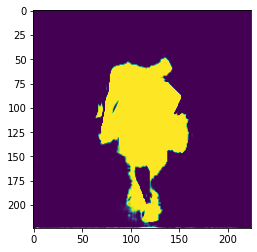

In [59]:
plt.imshow(pred)

In [66]:
pred[125] > 0.5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [60]:
pred.max()

1.0

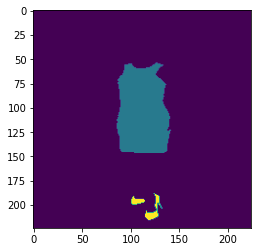

In [61]:
plt.imshow(mask)

In [ ]:
ma 